# Classification. Linear models and KNN

In [285]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [286]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [287]:
from sklearn.exceptions import NotFittedError

In [288]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # if X >= 0:
        return 1/(1+np.exp(-np.transpose(X@weights)))
        # else:
        #   return np.exp(X)/(1 + np.exp(X))
        
            
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return (np.sum(-y * np.log(y) - (1 - x) * np.log(1 - y))).mean()
        # m = x.shape[1]
        # return -1/m * (np.dot(x.T, np.log(y)) + np.dot((1-x).T, np.log(1-y)))

     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            #h = self.get_sigmoid(self, X)
            #delta = np.dot(X[i].T, (h-y[i]))/y[i].size
            #delta = (1/X.shape[0]) * np.dot(X[i].T, get_sigmoid(np.dot(X,self.weights_))-y)
            #delta = (1/X.shape[0]) * np.sum(y*np.log(get_sigmoid(X@self.weights_)) + (1-y)*np.log(1-get_sigmoid(X@self.weights_)))
            
            # delta = np.zeros(num_features)
            # for j in range(num_features):
            #     m = self.weights_ @ X_ext[j]
            #     delta += y[j]*X_ext[j,:] * (1 - 1/(1 + np.exp(-m*y[j]))) / len(y)  
            delta = - X_ext.T @ (y * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y)))) / len(y) + (self.weights_ / self.C)            
            delta -= (1/self.C) * self.weights_
            self.weights_ -= self.eta * delta

            if np.linalg.norm(self.eta*delta) < self.tol:
                break
            # if np.linalg.norm(delta) < self.tol:
            #     break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # return self.predict_proba(X)
        if self.predict_proba(X)> 0.5:
            return 1
        else:
            return -1
        

In [289]:
from sklearn import datasets
from sklearn import metrics

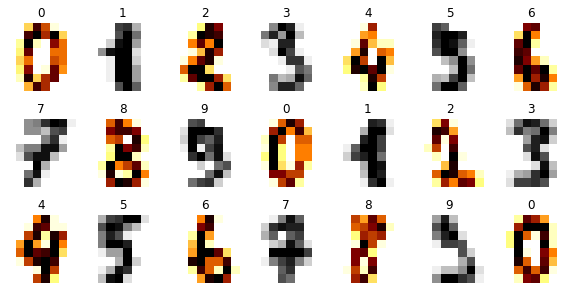

In [290]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [291]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [292]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [293]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [294]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [295]:
lr_clf.fit(X_train, y_train)

In [296]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [297]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [298]:
model = CustomLogisticRegression()

In [299]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


NameError: ignored

In [ ]:
train_acc, test_acc

In [ ]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [ ]:
## your code

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

In [ ]:
## your code

< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [ ]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.linalg.norm(np.subtract(X,Y))
        
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        pass
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [ ]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [ ]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [ ]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

In [ ]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [ ]:
#PATH = "./data/"

In [300]:
from google.colab import drive
drive.mount('/content/drive')
train_filepath = ('./drive/MyDrive/train.csv')
data = pd.read_csv(train_filepath, index_col="PassengerId")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [301]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


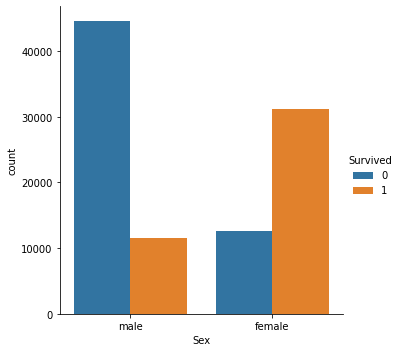

In [302]:
sns.catplot("Sex", data = data, hue = "Survived", kind="count")

< your thoughts >

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


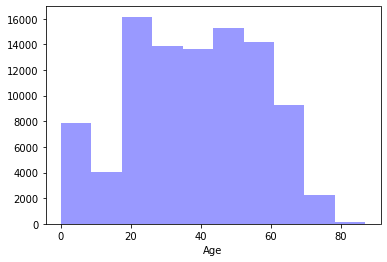

In [303]:
# Распределение пассажиров по возрасту
sns.distplot(a=data['Age'], kde=False, bins = 10, color = 'blue')

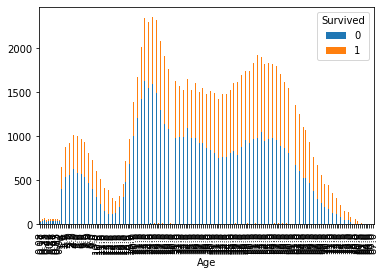

In [304]:
# Соотношение выживших и невыживших
age_survived = data.groupby(['Age', 'Survived'])
age_survived = age_survived.size().unstack()
age_survived.plot(kind='bar', stacked=True)

In [305]:
#делим людей на возрастные группы, где 1 - возраст до 10 лет и т.д.
data['Age_copy'] = data['Age']
data['Age_copy'] = data['Age_copy'].map(lambda age: (age // 10) + 1)

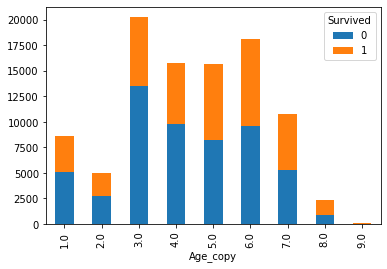

In [306]:
# Соотношение выживших и невыживших по возрастной группе
age_survived = data.groupby(['Age_copy', 'Survived'])
age_survived = age_survived.size().unstack()
age_survived.plot(kind='bar', stacked=True)

In [307]:
data.groupby('Survived')['Age'].mean()

Survived
0    36.708695
1    40.553799
Name: Age, dtype: float64

In [308]:
data.groupby('Survived')['Age'].median()

Survived
0    36.0
1    43.0
Name: Age, dtype: float64

Средний и мединный возраста выживших больше, чем не выживших. Это можно объяснить наличием более богатого жизненного опыта, а так же синтетическими данными( в оригинальных данных средний возраст вышивших был ниже)

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


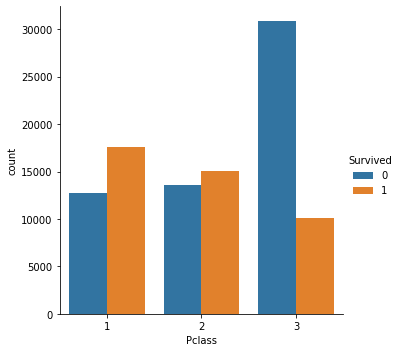

In [309]:
# График выживших в зависимости от класса
sns.catplot("Pclass", data = data, hue = "Survived", kind="count")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


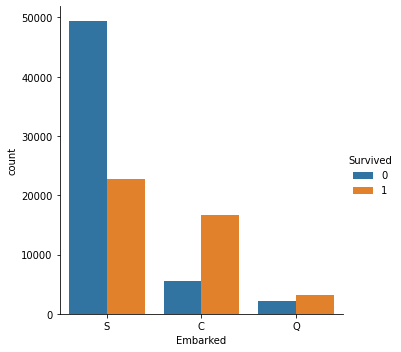

In [310]:
# График выживших в зависимости от порта отправления
sns.catplot("Embarked", data = data, hue = "Survived", kind="count")

<Figure size 720x288 with 0 Axes>

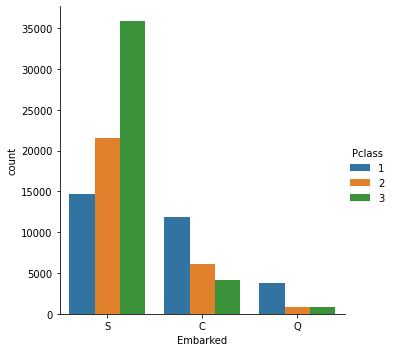

In [311]:
plt.figure(figsize=(10,4))
sns.catplot(x="Embarked", hue="Pclass", kind="count" ,data=data)
plt.show()

  Больше всего пассажиров плыло 3-м классом, вероятно из-за того, что он самый доступный и кают этого класса просто физически больше. Однако самая большая выживаемость была у тех, кто плыл 1-м классом. Это может быть связано с расположением кают 1-го класса выше, чем 2-го и третьего.
  Больше всего пассажиров отправлялось из порта Southampton, но самая высокая выживаемость была у пассажиров, севших в порту Cherbourg. Как видно из графика выше, может бытьсвязано с тем, что в порту Cherbourg большинство пассажиров плыли 1 классом.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [312]:
for col in data.columns:
    print('{} - {} %'.format(col, np.mean(data[col].isnull()*100)))

Survived - 0.0 %
Pclass - 0.0 %
Name - 0.0 %
Sex - 0.0 %
Age - 3.292 %
SibSp - 0.0 %
Parch - 0.0 %
Ticket - 4.623 %
Fare - 0.134 %
Cabin - 67.866 %
Embarked - 0.25 %
Age_copy - 3.292 %


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?


Я бы заполнил пропуски следующим образом:
В колонке Age  и Fare медианными значениями.
Колонку Embarked mode-м(наиболее часто встречаемым)
Колонку Fare mean-м (средним значением)
Колонку Ticket считаю не особо информативным. Ее можно удалить, либо поискать взаимосвязь билета с класса пассажира, и заполнить ее модом исходя из класса.
Колонка Cabin имеет почти 68% отсутствующих данных, ее можно удалить, либо сопоставить со значенем Survived, и сделать выводы, почему так много отсутствущих значений.


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [313]:
# Проверяем данные на наличие и количество Nan, типы данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
 11  Age_copy  96708 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 11.9+ MB


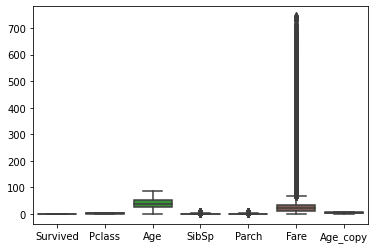

In [314]:
sns.boxplot(data=data)

In [315]:
# Убираем выбросы в колонке Fare(заменяем на nan)
for x in ['Fare']:
  Q1 =  data['Fare'].quantile(0.25)
  Q3 = data['Fare'].quantile(0.75)
  IQR = Q3 - Q1
  maks = (Q3+1.5*IQR)
  mins = (Q1-1.5*IQR)
  data.loc[data[x] < mins,x] = np.nan
  data.loc[data[x] > maks,x] = np.nan

In [316]:
# Исключаем дубликаты по имени и билету

key = ['Ticket','Name']
data = data.drop_duplicates(subset=key)
print(data.shape)

(99973, 12)


In [317]:
# Удаляем неинформативные колонки
data = data.drop('Name', axis=1)
data = data.drop('Ticket', axis=1)
data = data.drop('Cabin', axis=1)
print(data.shape)

(99973, 9)


In [318]:
# Заполняем пропуски в полезных колонках 
data["Age"] = data["Age"].fillna(data["Age"].mean())
data["Fare"] = data["Fare"].fillna(data["Fare"].mean())
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])
data["Fare"] = data["Fare"].fillna(data["Fare"].mean())

In [319]:
# Проверяем, что в данных отсутствуют Nan
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99973 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  99973 non-null  int64  
 1   Pclass    99973 non-null  int64  
 2   Sex       99973 non-null  object 
 3   Age       99973 non-null  float64
 4   SibSp     99973 non-null  int64  
 5   Parch     99973 non-null  int64  
 6   Fare      99973 non-null  float64
 7   Embarked  99973 non-null  object 
 8   Age_copy  96681 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 7.6+ MB


In [320]:
#Измени male  и female yf 0 и 1
d = {'male':0, 'female':1}
data['Sex'] = data['Sex'].apply(lambda x:d[x])

In [321]:
d = {'S':0, 'C':1, 'Q':2}
data['Embarked'] = data['Embarked'].apply(lambda x:d[x])

In [322]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_copy
PassengerId,,,,,,,,,
0,1,1,0,38.356875,2,0,27.140000,0,NaN
1,0,3,0,38.356875,0,0,13.350000,0,NaN
2,0,3,0,0.330000,1,2,20.290932,0,1.0
3,0,3,0,19.000000,0,0,13.040000,0,2.0
4,1,3,0,25.000000,0,0,7.760000,0,3.0


In [323]:
col_target = ['Survived'] # целевая колонка
col_train = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = data[col_train]
Y = data[col_target]

In [324]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

In [326]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, ..., 1, 1, 1])

In [327]:
accuracy_score(y_pred, y_test)

0.7594025073352894

In [328]:
log_reg.score(X_test, y_test)

0.7594025073352894

In [329]:
confusion_matrix(y_pred, y_test)

array([[13398,  3597],
       [ 3619,  9378]])

KNN:

In [330]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [331]:
scores = []
for k in range(1,15):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  scores.append(metrics.accuracy_score(y_test, y_pred))
print(scores)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[0.6829821285676181, 0.6856161643104828, 0.7146572419311816, 0.7118231528407576, 0.7264937316617764, 0.7260936249666577, 0.7333622299279808, 0.7313283542277941, 0.7380968258202187, 0.7356295012003201, 0.7388636969858629, 0.7356295012003201, 0.7393971725793544, 0.7351960522806081]


In [332]:
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7351960522806081

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [333]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.